In [1]:
from sklearn import linear_model
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
def prepros(train_file, test_file, ground_file):
    # read training data - It is the aircraft engine run-to-failure data.
    train_df = pd.read_csv(train_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    train_df=train_df.loc[:,0:25]

    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    train_df = train_df.sort_values(['id','cycle'])

    # read test data - It is the aircraft engine operating data without failure events recorded.
    test_df = pd.read_csv(test_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    test_df=test_df.loc[:,0:25]

    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    test_df = test_df.sort_values(['id','cycle'])

    #read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
    truth_df = pd.read_csv(ground_file, sep=" ", header=None)

    #remove the columns 1 because of NAN values
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    truth_df.columns = ['cycle']

    # Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
    ##TRAINING DATASET
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    train_df = train_df.merge(rul, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.drop('max', axis=1, inplace=True)

    # generate label columns for training data
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    #check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
    train_df.apply(lambda x: x.nunique())
    train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

    #TEST DATASET
    test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
    test_df.apply(lambda x: x.nunique())

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

    # MinMax normalization (from 0 to 1)
    min_max_scaler = preprocessing.MinMaxScaler()

    ###TRAIN#####
    train_df['cycle_norm'] = train_df['cycle']
    cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)

    ####TEST#####
    test_df['cycle_norm'] = test_df['cycle']
    test_df['id_norm'] = test_df['id']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)

    #### Generating input data
    # pick the feature columns 
    sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

    # generate sequences and convert to numpy array
    X_train = train_df[sequence_cols]

    #obtain the last cycle data for each test battery
    test_df=test_df.loc[test_df.groupby('id').cycle.idxmax()]
    X_test = test_df[sequence_cols]
    # Generate labels
    y_train=train_df['RUL']
    y_test=test_df['RUL']
    return (X_train, y_train, X_test, y_test)

In [2]:
X_train_1, y_train_1, X_test_1, y_test_1 = prepros('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt')
X_train_2, y_train_2, X_test_2, y_test_2 = prepros('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt')
X_train_3, y_train_3, X_test_3, y_test_3 = prepros('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt')
X_train_4, y_train_4, X_test_4, y_test_4 = prepros('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
random_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss': ['huber','squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
    'penalty': ['l2','l1','elasticnet']
}

print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
sgd = linear_model.SGDRegressor(shuffle=False, max_iter=None, tol=None)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
sgd_random_1 = GridSearchCV(estimator = sgd, param_grid = random_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the random search model
sgd_random_1.fit(X_train_1, y_train_1)
sgd_random_1.best_params_

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
sgd = linear_model.SGDRegressor(shuffle=False, max_iter=None, tol=None)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
sgd_random_2 = GridSearchCV(estimator = sgd, param_grid = random_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the random search model
sgd_random_2.fit(X_train_2, y_train_2)
sgd_random_2.best_params_

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
sgd = linear_model.SGDRegressor(shuffle=False, max_iter=None, tol=None)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
sgd_random_3 = GridSearchCV(estimator = sgd, param_grid = random_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the random search model
sgd_random_3.fit(X_train_3, y_train_3)
sgd_random_3.best_params_

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
sgd = linear_model.SGDRegressor(shuffle=False,max_iter=None, tol=None)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
sgd_random_4 = GridSearchCV(estimator = sgd, param_grid = random_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the random search model
sgd_random_4.fit(X_train_4, y_train_4)
sgd_random_4.best_params_

In [3]:
import time

def training_func(X_train_data, y_train_data, alpha_, loss_, penalty_):
    clf = linear_model.SGDRegressor(shuffle=False, max_iter=None, tol=None, alpha=alpha_, loss=loss_, penalty=penalty_)
    start = time.time()
    clf.fit(X_train_data, y_train_data)
    end = time.time()
    training_time = end - start
    return (clf, training_time)

In [4]:
#{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l1'}
clf_1, training_time_1 = training_func(X_train_1, y_train_1,1.0,'squared_loss','l1')
#{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l1'}
clf_2, training_time_2 = training_func(X_train_2, y_train_2,1.0,'squared_loss','l1')
#{'alpha': 0.01, 'loss': 'squared_loss', 'penalty': 'l2'}
clf_3, training_time_3 = training_func(X_train_3, y_train_3,0.01,'squared_loss','l2')
#{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l1'}
clf_4, training_time_4 = training_func(X_train_4, y_train_4,1.0,'squared_loss','l1')

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19

In [5]:
y_pred_1 = clf_1.predict(X_test_1)
y_pred_2 = clf_2.predict(X_test_2)
y_pred_3 = clf_3.predict(X_test_3)
y_pred_4 = clf_4.predict(X_test_4)

In [6]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
def plot_pred(y_pred, y_test):
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred, color="blue")
    plt.plot(y_test.values, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_RF_verify.png")

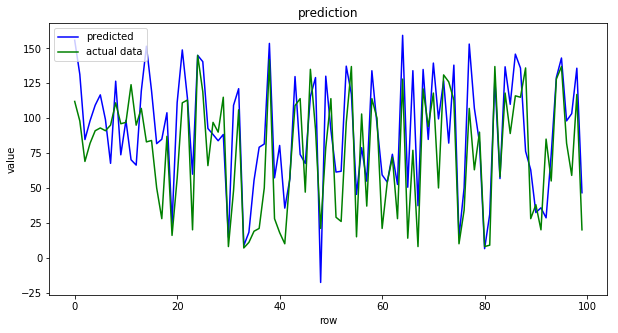

In [7]:
plot_pred(y_pred_1, y_test_1)

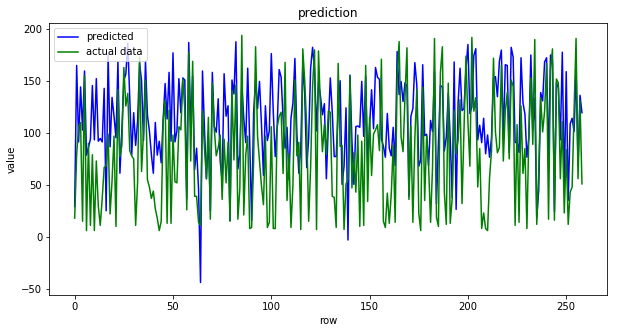

In [8]:
plot_pred(y_pred_2, y_test_2)

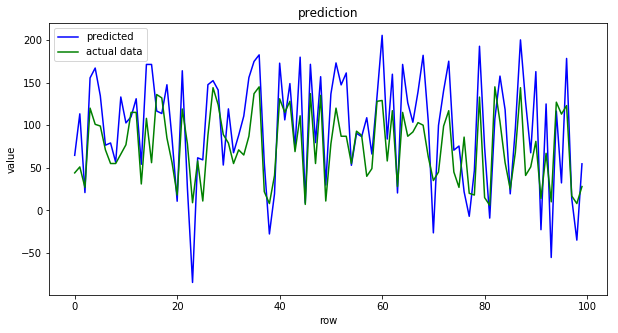

In [9]:
plot_pred(y_pred_3, y_test_3)

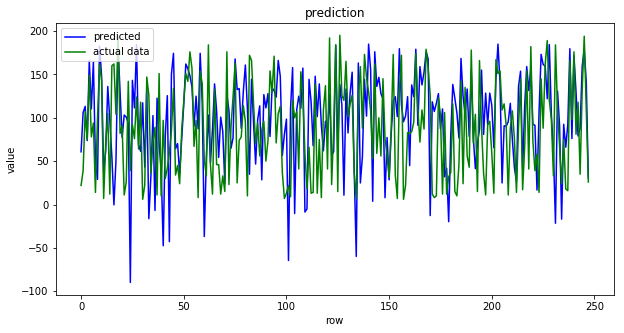

In [10]:
plot_pred(y_pred_4, y_test_4)

In [11]:
def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s


def rmse(true, pred):
    d_squared = (pred - true)**2
    err = np.mean(d_squared)
    err = np.sqrt(err)
    return err


def mae(true,pred):
    d=abs(pred - true)
    err=np.mean(d)
    return err

y_test = [y_test_1.values,y_test_2.values,y_test_3.values,y_test_4.values]
y_pred = [y_pred_1,y_pred_2,y_pred_3,y_pred_4]

sf_all = [scoring_function(test,pred) for test, pred in zip(y_test, y_pred)]
rmse_all = [rmse(test,pred) for test, pred in zip(y_test, y_pred)]
mae_all = [mae(test,pred) for test, pred in zip(y_test, y_pred)]
cor_all =[np.corrcoef(test, pred) for test, pred in zip(y_test, y_pred)]
all_training_time = [training_time_1,training_time_2,training_time_3,training_time_4]

In [12]:
d = {'Scoring Function': sf_all, 'RMSE': rmse_all, 'MAE':mae_all, 'Correlation':cor_all, 'Training Time': all_training_time}
def final_results(d):
    df = pd.DataFrame(data=d)
    df.index += 1
    df.index.name='CMAPSS Dataset'
    return df

final_results(d)

,Correlation,MAE,RMSE,Scoring Function,Training Time
CMAPSS Dataset,,,,,
1,"[[1.0, 0.7868599900728408], [0.786859990072840...",25.202195,30.402627,2.477963e+03,0.048674
2,"[[1.0, 0.676156748347123], [0.676156748347123,...",43.242314,51.765803,6.316578e+04,0.052422
3,"[[1.0, 0.7983904993983281], [0.798390499398328...",37.807860,45.256933,2.956974e+04,0.016965
4,"[[1.0, 0.41313923386580725], [0.41313923386580...",48.128130,59.837513,8.646219e+08,0.052395


In [ ]:
print(cor_all)

In [ ]:
clf = linear_model.SGDRegressor(max_iter=None, penalty='elasticnet', tol=1e-3)

import time
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print(end - start)

In [ ]:
# Using the scoring function

def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s


def rmse(true, pred):
    d_squared = (pred - true)**2
    err = np.mean(d_squared)
    err = np.sqrt(err)
    return err


def mae(true,pred):
    d=abs(pred - true)
    err=np.mean(d)
    return err

In [ ]:
y_pred = clf.predict(X_test)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred, color="blue")
plt.plot(y_test.values, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_RF_verify.png")

In [ ]:
sf = scoring_function(y_test.values,y_pred)
rmse_err = rmse(y_test.values,y_pred)
mae_err = mae(y_test.values,y_pred)
cor=np.corrcoef(y_test.values, y_pred)

print(sf,rmse_err,mae_err,cor)